# NAM Clustering algorithms demo

A quick notebook to demonstrate some clustering algorithms!

You will need...

* Python 3.6+
* numpy
* matplotlib
* scikit-learn
* hdbscan

## Imports


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import hdbscan
import time

import sklearn.cluster
import sklearn.mixture
from pathlib import Path

# Set colour cycle to be more colourblind-friendly
# Using https://github.com/matplotlib/matplotlib/issues/9460#issuecomment-875185352
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]) 

## Data
This data is taken from the [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/advanced_hdbscan.html) docs. Let's take a look at it!

This is a relatively difficult dataset for most algorithms. Simple algorithms will look bad in this example, but there are certainly simpler cases where the more sophisticated algorithms are overkill (and certain cases where the sophisticated algorithms will mess up, _badly._)

In [4]:
data = np.load("clusterable_data.npy")

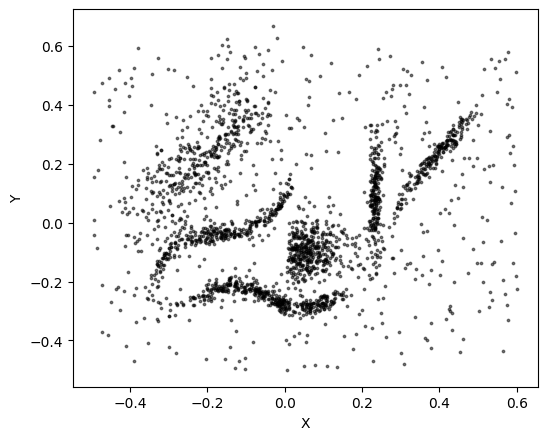

In [117]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

ax.scatter(data[:, 0], data[:, 1], s=3, c='k', alpha=0.5)
ax.set(xlabel='X', ylabel='Y')

fig.savefig("plots/base_data.png")

There are various "stringy" clusters, including a less dense one in the top-left and a more circular one in the middle. Also note that there are many "noise points".

## Helper function
Everything I'll use here uses the standard scikit-learn API, so we can write a function to automate this for us!

In [102]:
def run_clustering_algorithm(data, algorithm, savename=None, close_fig=False, plot_kwargs=None, 
                             scatter_kwargs=None, legend=True, *args, **kwargs):
    # Run the clustering
    print("Running clustering algorithm!")
    
    start_time = time.time()
    clusterer = algorithm(*args, **kwargs)
    labels = clusterer.fit_predict(data)
    run_time = time.time() - start_time
    
    print(f"  clustering took {run_time:.4f} seconds")
    
    # Plot the results
    print("Plotting results!")
    
    # Set default plot size etc.
    final_plot_kwargs = dict(figsize=(6, 5), dpi=100)
    if plot_kwargs is not None:
        final_plot_kwargs.update(plot_kwargs)
    
    # Make the plot!
    fig, ax = plt.subplots(**final_plot_kwargs)
    
    # Cycle over all clusters, plotting points    
    for a_label in np.unique(labels):
        matching_labels = labels == a_label
        
        # Special case for noise points, otherwise plot normally
        if a_label == -1:
            ax.scatter(data[matching_labels, 0], data[matching_labels, 1], 
                       s=3, c='k', alpha=0.5, label='Unclustered')
        else:
            ax.scatter(data[matching_labels, 0], data[matching_labels, 1], 
                       s=3, label=a_label)
        
    # Legend, if desired
    if legend:
        ax.legend(edgecolor='k', fontsize=8)
        
    # Other beautification
    ax.set(title=f"{algorithm.__name__} ({run_time:.4f} s)", 
           xlabel='X', ylabel='Y')
    
    # Save, if desired
    if savename is not None:
        fig.savefig("plots/" + savename, bbox_inches="tight")
        
    # Close the on quit, if desired
    if close_fig:
        plt.close(fig)

## The clustering algorithms
Let's try various algorithms! Feel free to play around with the parameters.

### K-Means
The archetypal (and most simple) clustering algorithm...

Running clustering algorithm!
  clustering took 0.1007 seconds
Plotting results!


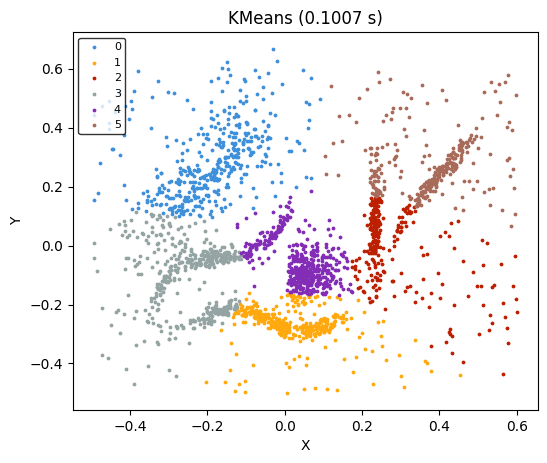

In [118]:
run_clustering_algorithm(data, sklearn.cluster.KMeans, n_clusters=6, savename='KMeans')

Basic algorithm; some things are roughly separated, but not so well.

### Gaussian mixture models
Can be considered a generalisation of the KMeans algorithm that allows clusters to have arbitrary shapes (i.e. standard deviations.)

Running clustering algorithm!
  clustering took 0.8371 seconds
Plotting results!


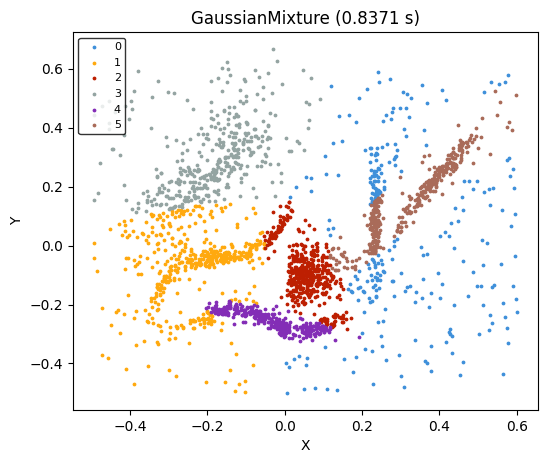

In [119]:
# I use n_init=10 (i.e. 10 trials and pick the best) for more consistent results.
# But, if this is really slow, you may want to lower that parameter!
run_clustering_algorithm(
    data, sklearn.mixture.GaussianMixture, n_components=6, n_init=10, savename='GaussianMixtureModels')

This does a better job, especially with some of the sparse objects! However, some clusters aren't so well separated.

### Agglomerative clustering
A common hierarchical algorithm

Running clustering algorithm!
  clustering took 0.0566 seconds
Plotting results!


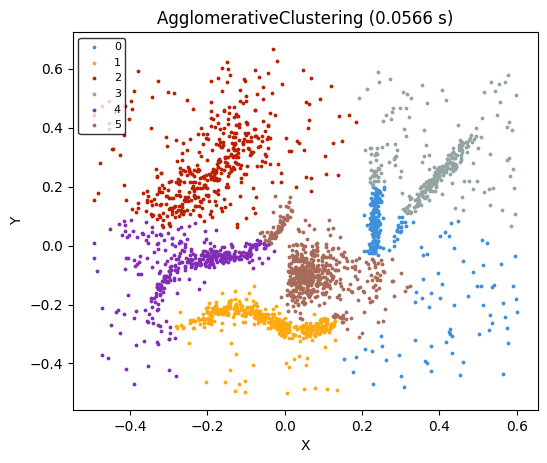

In [120]:
run_clustering_algorithm(
    data, sklearn.cluster.AgglomerativeClustering, n_clusters=6, linkage='ward', savename='AgglomerativeClustering')

That's a better result! The lower and upper (sparse) clusters are quite well separated. However, some clsuters are still merged together somewhat.

### DBSCAN

The first density-based algorithm here! Also one of the most common.

Running clustering algorithm!
  clustering took 0.0060 seconds
Plotting results!


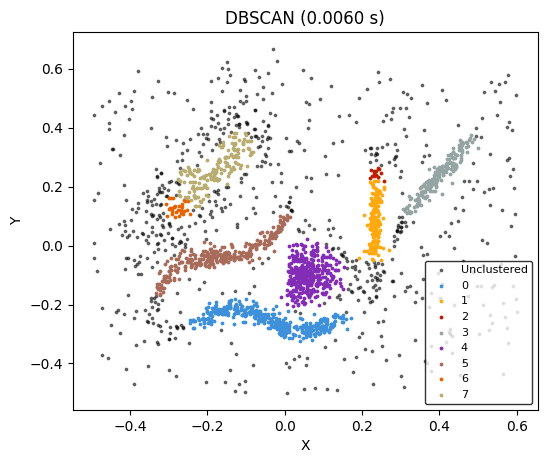

In [121]:
# The "eps" parameter requires a lot of playing around to set
run_clustering_algorithm(
    data, sklearn.cluster.DBSCAN, eps=0.03, min_samples=20, savename='DBSCAN')

Not bad! Although a couple of clusters have been erroneously split, and the sparse one in the top-left seems to be missing a few members.

### OPTICS

An extension of DBSCAN that can set epsilon autonomously!

Running clustering algorithm!
  clustering took 0.8258 seconds
Plotting results!


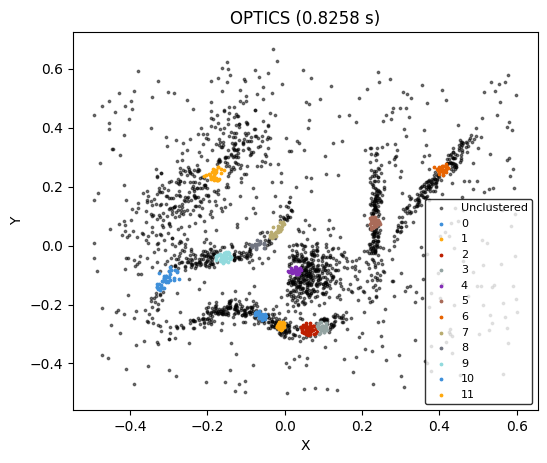

In [122]:
run_clustering_algorithm(
    data, sklearn.cluster.OPTICS, min_samples=20, savename='OPTICS')

I really struggled to get this to work nicely. Tweet me @emilydoesastro if you can do better

### HDBSCAN

An further extension of DBSCAN that combines concepts from both density-based clustering _and_ hierarchical clustering.

Running clustering algorithm!
  clustering took 0.0984 seconds
Plotting results!


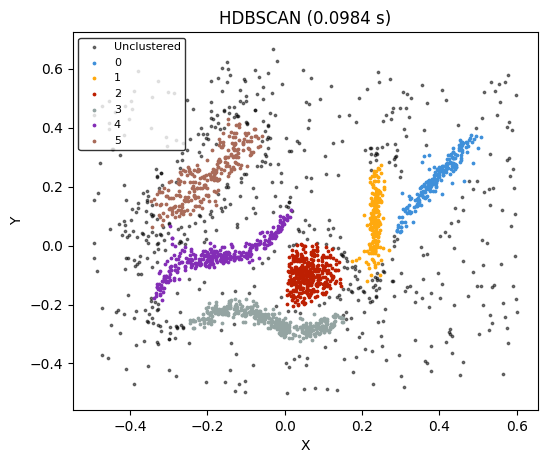

In [123]:
run_clustering_algorithm(
    data, hdbscan.HDBSCAN, min_cluster_size=20, savename='HDBSCAN')

It works really nicely on this data. HDBSCAN is my favourite! (But check out my talk for a discussion of the caveats the algorithm still has...)

## Plots

I made a few plots for the presentation, this is the code that made them by running DBSCAN a few times.

In [114]:
for an_eps in np.linspace(0.01, 0.1, num=10):
    run_clustering_algorithm(
        data, sklearn.cluster.DBSCAN, eps=an_eps, min_samples=20, savename=f"dbscan_{an_eps:.2f}.png", close_fig=True)

Running clustering algorithm!
  clustering took 0.0048 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0050 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0057 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0063 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0072 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0078 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0079 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0088 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0094 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0101 seconds
Plotting results!
